In [1]:
from src.main.graph_generation import main

import numpy as numpy
import nibabel as nib
import torch
import glob
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from sklearn.preprocessing import MinMaxScaler

import numpy as np

from skimage.segmentation import slic
import numpy as np
from collections import Counter

In [2]:
from scipy.ndimage import zoom
from skimage.transform import rescale

In [3]:
from src.main.graph_generation import Nii_loader

nl = Nii_loader(file_id='004')

In [4]:
nl.normalize_all()
np.unique(nl.mask), nl.mask.shape

(array([0., 1., 2., 3.]), (240, 240, 155))

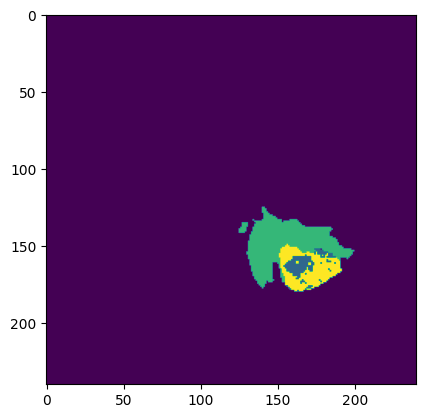

In [8]:
plt.imshow(nl.mask[:, :, int(155/2)])

In [9]:
nl.downsample_all(0.5)

before downsampling: (240, 240, 155)
after downsampling: (120, 120, 78)
--------------------------
before downsampling: (240, 240, 155)
after downsampling: (120, 120, 78)
--------------------------
before downsampling: (240, 240, 155)
after downsampling: (120, 120, 78)
--------------------------
before downsampling: (240, 240, 155)
after downsampling: (120, 120, 78)
--------------------------
before downsampling: (240, 240, 155)
after downsampling: (120, 120, 78)


In [10]:
nl.mask.shape

(120, 120, 78)

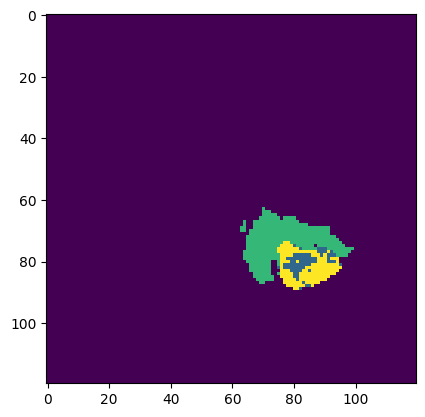

In [11]:
plt.imshow(nl.mask[:, :, 39])

In [10]:
from skimage.transform import rescale

In [16]:
type(nl.mask)

numpy.memmap

In [11]:
downsampled_data = rescale(
nl.mask, 0.5, anti_aliasing=True, mode="reflect"
)

print("is_label runs")
# Use nearest-neighbor interpolation for label data
downsampled_data = rescale(
    nl.mask, 0.5,
    anti_aliasing=False,
    mode="reflect",
    order=0,
    preserve_range=True,
)
# downsampled_data = downsampled_data.astype(img.dtype)

is_label runs


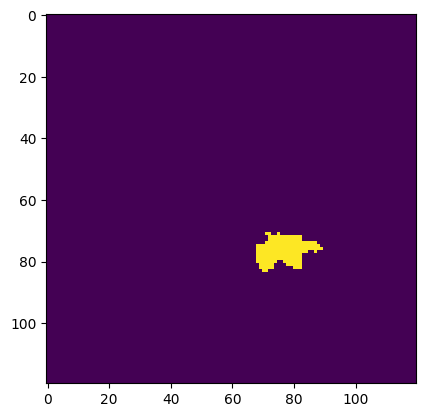

In [15]:
plt.imshow(downsampled_data[:, :, 30])

In [2]:
import os
import torch
from torch_geometric.data import Dataset

class CustomGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.file_list = [
            os.path.join(self.root, f)
            for f in os.listdir(self.root)
            if f.endswith(".pt") and "001" not in f
        ]

    @property
    def raw_file_names(self):
        # No raw files to process
        return []

    @property
    def processed_file_names(self):
        # This is actually not needed because we handle file paths in __init__
        return [f for f in os.listdir(self.processed_dir) if f.endswith('.pt')]

    def len(self):
        return len(self.file_list)

    def get(self, idx):
        # Load only the requested graph
        return torch.load(self.file_list[idx])

# Initialize your dataset
dataset = CustomGraphDataset(root="../../data/processed/0_05__1000/")
for data in dataset:
    print(data)

Data(x=[791, 4], edge_index=[2, 15819], edge_attr=[15819, 1], y=[791])
Data(x=[854, 4], edge_index=[2, 16386], edge_attr=[16386, 1], y=[854])
Data(x=[802, 4], edge_index=[2, 16302], edge_attr=[16302, 1], y=[802])
Data(x=[882, 4], edge_index=[2, 18332], edge_attr=[18332, 1], y=[882])
Data(x=[836, 4], edge_index=[2, 16044], edge_attr=[16044, 1], y=[836])
Data(x=[848, 4], edge_index=[2, 16226], edge_attr=[16226, 1], y=[848])
Data(x=[864, 4], edge_index=[2, 16096], edge_attr=[16096, 1], y=[864])
Data(x=[823, 4], edge_index=[2, 16761], edge_attr=[16761, 1], y=[823])
Data(x=[829, 4], edge_index=[2, 16699], edge_attr=[16699, 1], y=[829])
Data(x=[837, 4], edge_index=[2, 16271], edge_attr=[16271, 1], y=[837])
Data(x=[820, 4], edge_index=[2, 16128], edge_attr=[16128, 1], y=[820])
Data(x=[805, 4], edge_index=[2, 15427], edge_attr=[15427, 1], y=[805])
Data(x=[882, 4], edge_index=[2, 16176], edge_attr=[16176, 1], y=[882])
Data(x=[835, 4], edge_index=[2, 15505], edge_attr=[15505, 1], y=[835])
Data(x

In [58]:
from torch_geometric.loader import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
next(iter(dataloader))

DataBatch(x=[3329, 4], edge_index=[2, 66839], edge_attr=[66839, 1], y=[3329], batch=[3329], ptr=[5])

In [61]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 16)
        self.conv3 = GCNConv(16, num_classes)

    def forward(self, graph):
        
        x, edge_index, edge_attr = graph.x.to(torch.float), graph.edge_index.to(torch.int64), graph.edge_attr.to(torch.float)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

model_test = GCN(num_features=4, num_classes=4).to('cuda')

In [62]:
all_labels = []
for batch in dataloader:
    all_labels.extend(batch.y.numpy())

class_counts = Counter(all_labels)
total_count = float(sum(class_counts.values()))
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights[i] for i in range(4)], dtype=torch.float32).to("cuda")


In [63]:
from sklearn.metrics import accuracy_score

# model = GCN(num_features=graph.num_node_features, num_classes=5).to('cuda')
optimizer = torch.optim.Adam(model_test.parameters(), lr=0.01)

model_test.train()
for epoch in range(2000):  # number of epochs
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for batch in dataloader:
        optimizer.zero_grad()
        batch = batch.to('cuda')
        out = model_test(batch)

        loss = F.nll_loss(out, batch.y.to(torch.long), weight=weights)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(out, 1)
        total_correct += (predicted == batch.y.to(torch.long)).sum().item()
        total_samples += batch.y.size(0)
    
    train_accuracy = total_correct / total_samples
    
    # Print loss and accuracy
    if epoch % 10 == 0:
        average_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch} | Loss: {average_loss:.3f} | Train Accuracy: {train_accuracy:.4f}')



Epoch 0 | Loss: 1.375 | Train Accuracy: 0.5074
Epoch 10 | Loss: 1.179 | Train Accuracy: 0.7208
Epoch 20 | Loss: 1.106 | Train Accuracy: 0.8038
Epoch 30 | Loss: 1.085 | Train Accuracy: 0.8112
Epoch 40 | Loss: 1.065 | Train Accuracy: 0.8206
Epoch 50 | Loss: 1.049 | Train Accuracy: 0.8254
Epoch 60 | Loss: 1.036 | Train Accuracy: 0.8243
Epoch 70 | Loss: 1.032 | Train Accuracy: 0.8231
Epoch 80 | Loss: 1.027 | Train Accuracy: 0.8256
Epoch 90 | Loss: 1.010 | Train Accuracy: 0.8202
Epoch 100 | Loss: 1.008 | Train Accuracy: 0.8258
Epoch 110 | Loss: 0.995 | Train Accuracy: 0.8208
Epoch 120 | Loss: 0.995 | Train Accuracy: 0.8212
Epoch 130 | Loss: 0.984 | Train Accuracy: 0.8211
Epoch 140 | Loss: 0.979 | Train Accuracy: 0.8168
Epoch 150 | Loss: 0.967 | Train Accuracy: 0.8199
Epoch 160 | Loss: 0.968 | Train Accuracy: 0.8214
Epoch 170 | Loss: 0.966 | Train Accuracy: 0.8116
Epoch 180 | Loss: 0.957 | Train Accuracy: 0.8182
Epoch 190 | Loss: 0.949 | Train Accuracy: 0.8237
Epoch 200 | Loss: 0.948 | Train

In [64]:
sample = next(iter(dataloader)).to("cuda")
sample

DataBatch(x=[3329, 4], edge_index=[2, 66839], edge_attr=[66839, 1], y=[3329], batch=[3329], ptr=[5])

In [65]:
model_test(sample).argmax(dim=1).detach().to("cpu")[0:800]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [66]:
sample.y[0: 800]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [78]:
import torch

def get_classwise_acc(true_labels, predicted_labels):
    # true_labels, predicted_labels = sample.y.detach().to("cpu"), model_test(sample).argmax(dim=1).detach().to("cpu")

    true_positives = {}
    total_samples = {}

    for true, pred in zip(true_labels, predicted_labels):
        if true.item() in total_samples:
            total_samples[true.item()] += 1
        else:
            total_samples[true.item()] = 1

        if true == pred:
            if true.item() in true_positives:
                true_positives[true.item()] += 1
            else:
                true_positives[true.item()] = 1

    # Calculate class-wise accuracy
    class_wise_accuracy = {}
    for cls in total_samples:
        if cls in true_positives:
            class_wise_accuracy[cls] = true_positives[cls] / total_samples[cls]
        else:
            class_wise_accuracy[cls] = 0.0  # No true positives for this class

    print("Class-wise Accuracy:", class_wise_accuracy)


In [75]:
validation_sample = torch.load("../../data/processed/validation/008.pt").to("cuda")

In [77]:
model_test(validation_sample).detach().cpu().argmax(dim=1)

tensor([0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
        2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 1, 1, 1, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 2,
        2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 3, 0,
        2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0,
        0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0,
        0, 0, 3, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 2, 2, 3, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 1, 3,
        0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2,

In [32]:
validation = torch.load("../../data/processed/008.pt")
validation

Data(x=[819, 4], edge_index=[2, 16479], edge_attr=[16479, 1], y=[819])

In [79]:
get_classwise_acc(validation.y, model_test(validation.to("cuda")).argmax(dim=1))

# reminder {1:necrotic, 2: edema, 3:enhancing}

Class-wise Accuracy: {0.0: 0.6824408468244084, 2.0: 0.6666666666666666, 3.0: 0.0}


In [26]:
t = torch.load("../../data/processed/0_05__1000/007.pt").to("cuda")
t.y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

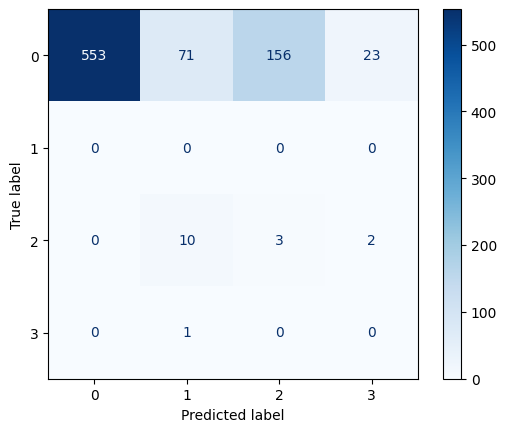

Class-wise Accuracy: [0.6886675       nan 0.2       0.       ]


/tmp/ipykernel_66121/2201379399.py:13: RuntimeWarning: invalid value encountered in divide
  class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)


In [83]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels, predicted_labels = validation.y.detach().cpu(), model_test(validation.to("cuda")).argmax(dim=1).detach().cpu()

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)
print("Class-wise Accuracy:", class_wise_accuracy)


In [11]:
torch.load("../../data/processed/0_05__1000/003.pt")

Data(x=[855, 4], edge_index=[2, 16073], edge_attr=[16073, 1], y=[855])

In [27]:
import graph_generation as g

In [28]:
nii_loader = g.Nii_loader()

FileNotFoundError: No such file or no access: 'data/raw/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'

In [29]:
import pickle

def load_supervoxels(filename: str):
    with open(filename, 'rb') as f:
        list_of_supervoxels = pickle.load(f)
    return list_of_supervoxels



In [30]:
from graph_generation import SuperVoxel, Voxel

In [31]:
l = load_supervoxels("../../pickleGraphTest.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../../pickleGraphTest.pkl'

In [9]:
!ls -la ../../

total 1276
drwxr-xr-x 10 tryfonm tryfonm   4096 May 25 04:51 .
drwxr-xr-x 41 tryfonm tryfonm   4096 Apr 27 17:30 ..
drwxr-xr-x  8 tryfonm tryfonm   4096 May 23 02:48 .git
-rw-r--r--  1 tryfonm tryfonm     93 Feb 12 00:07 .gitignore
-rw-r--r--  1 tryfonm tryfonm    725 Dec  1 22:12 Makefile
drwxr-xr-x  2 tryfonm tryfonm   4096 May  7 16:51 backup
drwxr-xr-x  4 tryfonm tryfonm   4096 May 23 22:40 data
drwxr-xr-x  2 tryfonm tryfonm   4096 Feb 23 13:35 models
drwxr-xr-x  4 tryfonm tryfonm   4096 May 23 21:49 notebooks
-rw-r--r--  1 tryfonm tryfonm    233 May 10 16:23 notes
-rw-r--r--  1 tryfonm tryfonm 817680 May 25 04:51 pickleGraphTest.py
-rw-r--r--  1 tryfonm tryfonm   1624 Nov 19  2023 requirements_backup.txt
drwxr-xr-x  3 tryfonm tryfonm   4096 Dec  1 22:12 runs
-rw-r--r--  1 tryfonm tryfonm    901 Apr  5 10:27 sista_error
-rw-r--r--  1 tryfonm tryfonm 423376 May 23 22:31 someRandomGraph.pt
drwxr-xr-x  4 tryfonm tryfonm   4096 Nov 19  2023 src
drwxr-xr-x  7 tryfonm tryfonm   4096 Nov 

In [ ]:
predictions = torch.zeros_like(torch.tensor(sample_image))
for sv_index, sv in enumerate(list_of_supervoxels):
    indices = tuple(zip(*sv.list_of_voxel_indices))
    predictions[indices] = predicted_labels[sv_index]